# MODELO EN PRODUCCIÓN:

Se quiere saber si el precio del mercado intradiario del día D (D = today + 1) será inferior {1} o superior {0} al precio del mercado diario. Existe un gap en el que no se apuesta por ninguna de las dos opciones. Este gap se representa en la tabla de resultados con el valor 0.5 (ni 0 ni 1).

Para ello, se debe cubrir previamente la plantilla excel *Plantilla.xlsx* con los datos internos específicos y ejecutar este notebook.

La salida del modelo se guardará en *'Resultados/data&model/resultado/resultado_aaaa-mm-dd.csv'*.

In [79]:
#Importamos librerías

import pandas as pd
import numpy as np
import datetime as dt
import pickle
import Funciones_Extraccion as datos

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt


%matplotlib inline
plt.style.use('ggplot')

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [80]:
pd.options.display.max_columns= None

### Parámetros

In [81]:
path_model='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo4/'  #Si se descarga el modelo del repositorio, cambiar esta ruta a '/data&model/'
path_plantilla='./data&model/'
path_salida='./data&model/resultado/'
columns=['PERIODO', 'WD', 'PRECIO_MD_ESP', 'P48_EOLICA', 'P48_DEMANDA',
       'POT_DISP_CARBON', 'CARBON_D-1', 'EMB_ANUALES', 'EMB_HIPERANUALES']

d={10008: 'P48_CARBON',
   475: 'POT_DISP_HULLA_ANT',  #Los tendremos que sumar para obtener MW disponibles Carbón
   476: 'POT_DISP_HULLA_SB'
  }

#Para los datos del día anterior (today)
fecha_ini_ant=dt.datetime.today().strftime('%Y-%m-%d') + ' 00:00:00'
fecha_fin_ant=dt.datetime.today().strftime('%Y-%m-%d') + ' 23:59:59'

#Para los datos del día de estudio (today + 1)
fecha_ini_prev=dt.datetime.strptime(fecha_ini_ant,'%Y-%m-%d %H:%M:%S') + dt.timedelta(days=1)
fecha_fin_prev=dt.datetime.strptime(fecha_fin_ant,'%Y-%m-%d %H:%M:%S') + dt.timedelta(days=1)

### Lectura datos externos - plantilla.###

Estos datos se tendrán que cumplimentar manualmente en la plantilla *Plantilla.xlsx*.

* Las previsiones de eólica, demanda las recibimos de un proveedor externo horariamente (en la realidad se podrá atacar a nuestro servidor a través de query insertándola en el notebook). Ejemplo de query:

```
  SELECT f.[FECHAVIENTO]
        ,f.[HORA]
        ,f.[VIENTO]
        ,f.[FECHAPREVISION]
  FROM (select [FECHAVIENTO], [HORA], max([FECHAPREVISION]) as maxprev
  from [BBDD]  -- representa la bbdd de nuestro servidor
  group by [FECHAVIENTO],[HORA]) as x
  inner join [BBDD] as f
  on f.[FECHAVIENTO]=x.[FECHAVIENTO] and f.[HORA]=x.[HORA] and f.[FECHAPREVISION]=maxprev 
  where f.[FECHAVIENTO]>= fecha_ini_prev 
  order by  f.[FECHAVIENTO],f.[HORA]

```
  
  
* El número de centrales arrancadas también las tenemos que descargar de nuestra bbdd interna a través de query.

```
  SELECT
      COUNT(DISTINCT(id_uprog)) AS NUM_PLANTAS
      ,format([FECHASESION],'yyyy-MM-dd') + ' ' + format([HORA]-1,'00') + ':00:00' as datetime
      FROM [BBDD]  -- representa la bbdd de nuestro servidor
      where id_uprog in ('','',...)  -- lista de unidades. Existen 26 centrales de carbón activas en España
	  and fechasesion=fecha_ini_ant
    GROUP BY datetime
    
```

* La previsión de precio la elabora otro departamento y lo facilita vía mail.

* La situación de los embalses se debe consultar en el Balance eléctrico diario REE y tomar el dato diario como horario. Link:

    https://www.ree.es/es/estadisticas-del-sistema-electrico-espanol/balance-diario

In [82]:
datos_externos=pd.read_excel(path_plantilla + 'Plantilla.xlsx')
datos_externos

,PRECIO_MD_ESP,P48_EOLICA,P48_DEMANDA,EMB_ANUALES,EMB_HIPERANUALES,NUM_PLANTAS_D-1
0,68.00,3077,29346,4543,3388,17
1,66.25,3221,27128,4543,3388,17
2,63.50,3330,25879,4543,3388,17
3,61.50,3373,25415,4543,3388,17
4,58.00,3456,25359,4543,3388,17
5,60.00,3792,26007,4543,3388,17
6,64.50,4292,28802,4543,3388,17
7,64.50,4675,33776,4543,3388,17
8,65.75,4879,37092,4543,3388,17
9,68.00,4982,38325,4543,3388,17


### Lectura datos esios

In [83]:
P48_CARBON=datos.solicita_datos_general(fecha_ini_ant,fecha_fin_ant,10008)  
P48_CARBON.columns=['P48_CARBON_D-1']
P48_CARBON.reset_index(inplace=True,drop=True)

POT_DISP_CARBON=datos.solicita_datos_general(fecha_ini_prev,fecha_fin_prev,475)+datos.solicita_datos_general(fecha_ini_prev,fecha_fin_prev,476)
POT_DISP_CARBON.columns=['POT_DISP_CARBON']
POT_DISP_CARBON.reset_index(inplace=True)

In [84]:
datos_esios=pd.DataFrame()
datos_esios=pd.concat([POT_DISP_CARBON,P48_CARBON],axis=1)
datos_esios

,datetime,POT_DISP_CARBON,P48_CARBON_D-1
0,2019-01-17 00:00:00,8606.7,5935.0
1,2019-01-17 01:00:00,8606.7,5678.8
2,2019-01-17 02:00:00,8606.7,5804.0
3,2019-01-17 03:00:00,8606.7,5566.2
4,2019-01-17 04:00:00,8606.7,5468.1
5,2019-01-17 05:00:00,8606.7,5845.4
6,2019-01-17 06:00:00,8606.7,5853.4
7,2019-01-17 07:00:00,8606.7,6064.5
8,2019-01-17 08:00:00,8606.7,6085.0
9,2019-01-17 09:00:00,8606.7,6085.1


### X final

Juntamos ambos datasets:

In [85]:
df=pd.DataFrame()
df=pd.concat([datos_esios,datos_externos],axis=1)
df.head()

,datetime,POT_DISP_CARBON,P48_CARBON_D-1,PRECIO_MD_ESP,P48_EOLICA,P48_DEMANDA,EMB_ANUALES,EMB_HIPERANUALES,NUM_PLANTAS_D-1
0,2019-01-17 00:00:00,8606.7,5935.0,68.00,3077,29346,4543,3388,17
1,2019-01-17 01:00:00,8606.7,5678.8,66.25,3221,27128,4543,3388,17
2,2019-01-17 02:00:00,8606.7,5804.0,63.50,3330,25879,4543,3388,17
3,2019-01-17 03:00:00,8606.7,5566.2,61.50,3373,25415,4543,3388,17
4,2019-01-17 04:00:00,8606.7,5468.1,58.00,3456,25359,4543,3388,17


Convertimos P48_CARBON_D-1 y NUM_CENTRALES_D-1 al feature CARBON_D-1

In [86]:
df['CARBON_D-1']=df['P48_CARBON_D-1']/df['NUM_PLANTAS_D-1']
df.head()

,datetime,POT_DISP_CARBON,P48_CARBON_D-1,PRECIO_MD_ESP,P48_EOLICA,P48_DEMANDA,EMB_ANUALES,EMB_HIPERANUALES,NUM_PLANTAS_D-1,CARBON_D-1
0,2019-01-17 00:00:00,8606.7,5935.0,68.00,3077,29346,4543,3388,17,349.117647
1,2019-01-17 01:00:00,8606.7,5678.8,66.25,3221,27128,4543,3388,17,334.047059
2,2019-01-17 02:00:00,8606.7,5804.0,63.50,3330,25879,4543,3388,17,341.411765
3,2019-01-17 03:00:00,8606.7,5566.2,61.50,3373,25415,4543,3388,17,327.423529
4,2019-01-17 04:00:00,8606.7,5468.1,58.00,3456,25359,4543,3388,17,321.652941


Features temporales: PERIODO, WD

In [87]:
df['datetime']=pd.to_datetime(df['datetime'],yearfirst=True,format='%Y-%m-%d %H:%M:%S')
df['PERIODO']=df['datetime'].dt.hour+1
df['WD']=pd.Series(df['datetime'].map(datos.WD))

In [88]:
X=df[columns]
X

,PERIODO,WD,PRECIO_MD_ESP,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
0,1,4,68.00,3077,29346,8606.7,349.117647,4543,3388
1,2,4,66.25,3221,27128,8606.7,334.047059,4543,3388
2,3,4,63.50,3330,25879,8606.7,341.411765,4543,3388
3,4,4,61.50,3373,25415,8606.7,327.423529,4543,3388
4,5,4,58.00,3456,25359,8606.7,321.652941,4543,3388
5,6,4,60.00,3792,26007,8606.7,343.847059,4543,3388
6,7,4,64.50,4292,28802,8606.7,344.317647,4543,3388
7,8,4,64.50,4675,33776,8606.7,356.735294,4543,3388
8,9,4,65.75,4879,37092,8606.7,357.941176,4543,3388
9,10,4,68.00,4982,38325,8606.7,357.947059,4543,3388


### Clasificador: model

In [89]:
model=pickle.load(open(path_model + "clfxb_4.pkl","rb"))

In [90]:
y_pred=list(model.predict(X))
prob=list(model.predict_proba(X))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [91]:
df_pred_prob=pd.DataFrame(prob,columns=['PROB_0','PROB_1'])
df_pred_prob['PRED']=np.empty(len(df_pred_prob['PROB_0']))

#límites para considerar fiable la previsión establecidos en el notebook *XGBoost.ipynb*:

lim1=0.6
lim1plus=0.7
lim0=0.65

for k,i in enumerate(y_pred):
    if (df_pred_prob['PROB_1'].iloc[k]>lim1) or (df_pred_prob['PROB_1'].iloc[k]<(1-lim0)):
        df_pred_prob['PRED'][k]=i   
    else:
        df_pred_prob['PRED'][k]=0.5
        
df_pred_prob.set_index(np.arange(1,25, step=1),inplace=True)

df_pred_prob['PROB_0']=-df_pred_prob['PROB_0']  #Por verlo mejor en el gráfico

df_pred_prob['LIM1']=np.ones(len(df_pred_prob['PRED']))*lim1
df_pred_prob['LIM1PLUS']=np.ones(len(df_pred_prob['PRED']))*lim1plus
df_pred_prob['LIM0']=np.ones(len(df_pred_prob['PRED']))*-lim0

df_pred_prob

,PROB_0,PROB_1,PRED,LIM1,LIM1PLUS,LIM0
1,-0.700495,0.299505,0.0,0.6,0.7,-0.65
2,-0.685891,0.314109,0.0,0.6,0.7,-0.65
3,-0.711650,0.288350,0.0,0.6,0.7,-0.65
4,-0.684435,0.315565,0.0,0.6,0.7,-0.65
5,-0.646139,0.353861,0.5,0.6,0.7,-0.65
6,-0.646674,0.353326,0.5,0.6,0.7,-0.65
7,-0.605866,0.394134,0.5,0.6,0.7,-0.65
8,-0.643768,0.356232,0.5,0.6,0.7,-0.65
9,-0.715151,0.284849,0.0,0.6,0.7,-0.65
10,-0.657273,0.342727,0.0,0.6,0.7,-0.65


Ploteo resultado a modo ilustrativo:

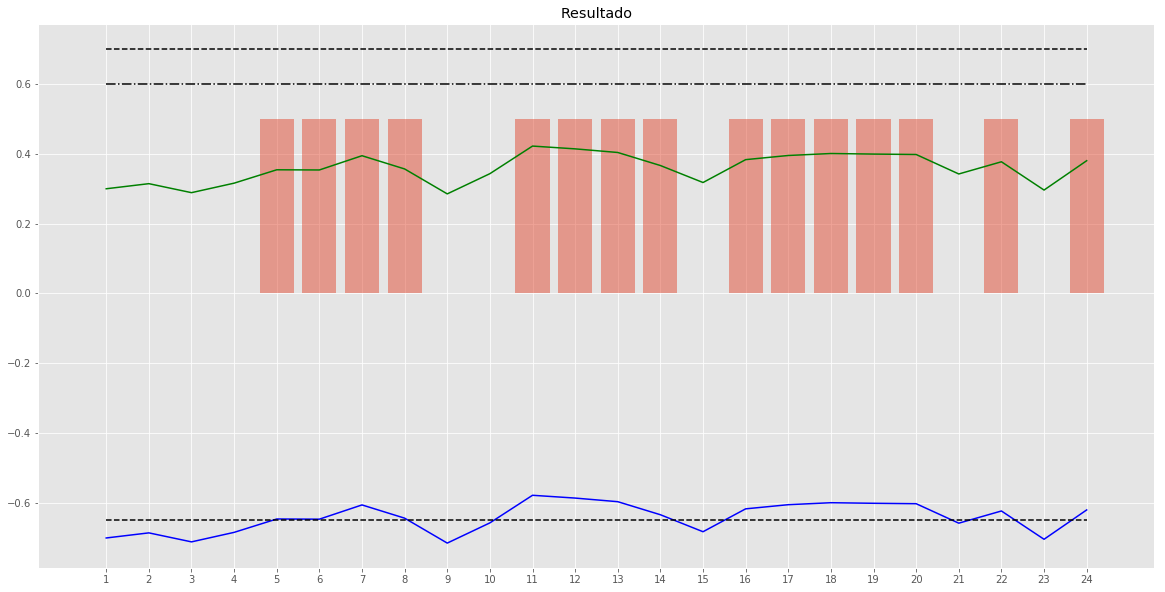

In [95]:
plt.figure(figsize=(20,10))

plt.bar(df_pred_prob.index.values,df_pred_prob['PRED'],alpha=0.5)
plt.plot(df_pred_prob['PROB_0'],'b')
plt.plot(df_pred_prob['PROB_1'],'g')
plt.plot(df_pred_prob['LIM1'],'-.',c='k')
plt.plot(df_pred_prob['LIM1PLUS'],'--',c='k')
plt.plot(df_pred_prob['LIM0'],'--',c='k')
plt.yticks=(np.arange(-1,1,step=0.2))
plt.title('Resultado')
plt.xticks(np.arange(1,25, step=1))
plt.ylim=([-1.2,1.2])
plt.savefig('./data&model/resultado/resultado_' + fecha_ini_prev.strftime('%Y-%m-%d') + '.png')
plt.show()

In [96]:
df_pred_prob.to_csv(path_salida + 'resultado_' + fecha_ini_prev.strftime('%Y-%m-%d') + '.csv',sep=';')